# Setup

In [2]:
# import libs
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import random
from PIL import Image
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

## Core Variables

In [3]:
# Global variables

channel_dict = {
    'RGB' : 3,
    'RGBcanny' : 4,
    'Grayscale' : 1,
    'Canny' : 1
}

fruit_array = ["apple","banana", "orange", "mixed"]

seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

reset_variables_dict = {
    #default variables
    'img_size' : 224,
    'epochs' : 64,
    'batchsize' : 10, 
    'validation_split' :0.1,
    'patience_value' : 5 ,
    'retain_aspect_ratio' : False,
    'use_classweights' : True,
    'use_random_oversampling' : False,
    'var_model' : 'Optimal',
    'var_data' : '01RELABELLED',
    'var_aug' : ['RGB', None],
}

# Need to autosave to load model in later steps! Setting to false will break this.
is_autosave = True

## Initialize Variables

In [5]:
# Set Variables
img_size = 1
epochs = 1
batchsize= 1
validation_split= 1
patience_value = 1
retain_aspect_ratio = False
use_classweights = False
use_random_oversampling = False

# Model Variant- See Function Definitions (Model Augmentation)
var_model = '' # 'FewLayers' # 'Overtuned' # 'Optimal' # '9x9'

# Data Variant- See \ML_Proj_Data\train
var_data = '' #'00BASE' # '01RELABELLED' # '02INCREASED' # '03EXPANDED'

# Augmentation Variant- See Function Definitions (Image Augmentation)
var_aug= ['RGB', None]
#First Aug
    #'RGB' # 'RGBcanny' # 'Grayscale' # 'Canny' 
#Second Aug
    #"rotation" #"translation" #"zoom" #"flip_horizontal" #"flip_vertical" #"flip_vertical_horizontal"


## Automatic Variables

In [6]:
# Automatic Variables
# model_data_id = '[NEW-MODEL-COMBINATION]'
# channels = 0

def set_automatic_variables():
    global model_data_id 
    model_data_id = '[{model}]-[{data}]-[{imgaug01}]-[{imgaug02}]'.format(
        model=var_model,
        data=var_data,    
        imgaug01=var_aug[0],
        imgaug02=var_aug[1]) 
    global channels
    channels=channel_dict[var_aug[0]]

set_automatic_variables()

# Functions

## Function Definitions (Image Layer Augmentation)

In [7]:
def first_augmentation_step(first_aug, img):
    '''
    For pre-processing image channels- Edge maps, color, etc.
    ALWAYS accept and return a PIL image
    ALWAYS return a PIL image, even if preprocessing with CV2
    '''

    if  first_aug=='RGB':
        return img
    
    elif first_aug=='RGBcanny':
        #convert to np ndarray
        PIL_array = np.array(img)

        ## debugging
        # print(type(PIL_array)) #np.ndarray
        # print(PIL_array.shape) #349,3

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        ## debugging
        # print(type(edges)) #np.ndarray
        # print(edges.shape) #349,

        final_img_array = np.dstack((PIL_array, edges))
        RGBwMap = Image.fromarray(final_img_array)
        return RGBwMap
    
    elif first_aug=='Grayscale':
        grayscale = img.convert('L')
        return grayscale
    
    elif first_aug=='Canny':
        PIL_array = np.array(img)

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        canny = Image.fromarray(edges)
        return canny
    
    else:
        print('ERROR: No image augmentation selected!')
    

## Function Definitions (Image Position Augmentation)

In [8]:
def second_augmentation_step(second_aug, img):
    '''
    For pre-processing image loci- translation, rotation, zooming, flipping 
    ALWAYS accept and return a PIL image
    '''

    second_aug_tuple = (
        "rotation",
        "translation",
        "zoom",
        "flip_horizontal",
        "flip_vertical",
        "flip_vertical_horizontal")
    
    # if no second aug, return
    if second_aug not in second_aug_tuple:
        return img
    
    # convert to preserve first aug
    if channels ==1:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2BGR)
    elif channels ==3:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_RGBA2BGR)
    elif channels==4:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_RGBA2BGRA)

        
    if second_aug == "rotation":
        cv2_final_image = cv2.rotate(cv2_image,cv2.ROTATE_90_CLOCKWISE)

    elif second_aug == "translation":
        tx = 50
        ty = 30
        translation_matrix = np.array([[1,0,tx],
                                   [0,1,ty]], dtype=np.float32)
        cv2_final_image = cv2.warpAffine(src=cv2_image, M=translation_matrix,dsize=(img.size[0], img.size[1]))

    elif second_aug == "zoom":
        zf = 2
        rows, cols = img.size[1],img.size[0]
        new_rows = int(rows*zf)
        new_cols = int(cols*zf)
        cv2_final_image = cv2.resize(cv2_image,(new_rows,new_cols))
  
    elif second_aug=='flip_horizontal':
        # Flip the image horizontally
        cv2_final_image = cv2.flip(cv2_image, 1)
        
    elif second_aug=='flip_vertical':
        # Flip the image vertically
        cv2_final_image = cv2.flip(cv2_image, 0)
        
    elif second_aug=='flip_vertical_horizontal':
        cv2_flipped_vertc_image = cv2.flip(cv2_image, 0)
        cv2_final_image = cv2.flip(cv2_flipped_vertc_image, 1)


    # convert to preserve first aug
    if channels ==1:
        edited_image = Image.fromarray(
            cv2.cvtColor(cv2_final_image, 
                         cv2.COLOR_BGR2RGB))
        edited_image = edited_image.convert('L')
        
    elif channels ==3:
        edited_image = Image.fromarray(
            cv2.cvtColor(cv2_final_image, 
                         cv2.COLOR_BGR2RGB))
        
    elif channels==4:
        edited_image = Image.fromarray(
            cv2.cvtColor(
                cv2_final_image, 
                cv2.COLOR_BGRA2RGBA))
        

    return edited_image

## Function Definitions (Model Augmentation)

In [9]:
def create_model(input_dimension, channels, model_type=None, num_classifications=4):
    '''
    Create a model
    Use 'flatten' or 'pooling' depending on settings
    '''
    model = tf.keras.Sequential()
    num_classifications=num_classifications
    
    if model_type=='FewLayers':
        model.add(tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(input_dimension, input_dimension, channels)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())

        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    elif model_type=='Overtuned':
        model.add(tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(input_dimension, input_dimension, channels)))
        model.add(tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2), (2, 2)))

        model.add(tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2), (2, 2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    elif model_type =='9x9':
        model.add(tf.keras.layers.Conv2D(64,(9,9),activation = 'relu',input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))
        model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    elif model_type=='Optimal':
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))

        # 4 classifications- Apple, Banana, Orange, Mixed
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))
        model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])


    

    return model

## Function Definitions (Primary)

In [10]:
# define func

def show_image(X_train,index):
    '''
    Display the image at the specific index of the reshaped array
    '''
    if not index  < X_train.shape[0]:
        print("Array does not contain your desired image index.")
    image_array = X_train[index]
    image = Image.fromarray(np.uint8(image_array))
    image.show()

def prep_train_data(subfolder_name, desired_size, var_aug_type):
    new_size = desired_size
    paths = []
    is_train_data=True
    
    for fruit in fruit_array:
        paths.append('ML_Proj_Data/train/{subfolder}/{fruit}'.format(subfolder=subfolder_name,fruit=fruit))

    return prep_data(paths, new_size, var_aug_type, is_train_data)

def prep_test_data(desired_size, var_aug_type):
    new_size = desired_size
    paths = []
    is_train_data=False

    for fruit in fruit_array:
        paths.append('ML_Proj_Data/test/{fruit}'.format(fruit=fruit))

    return prep_data(paths, new_size, var_aug_type, is_train_data)

def prep_data(paths, desired_size, var_aug_type, is_train_data):
    '''
    Pre-process all images in each of the 4 paths.
    '''
    new_size = desired_size

    for i in range(len(paths)):
        data = read_img_data(paths[i],new_size, var_aug_type, is_train_data)
        
        #test if it works by showing image
        # show_image(data,0)
        # show_image(data,1)

        try: 
            # concatenate if initialized
            X = np.concatenate((X,data))
        except:
            # initialize if not
            X = data

        y_onehots = map_type_to_onehot(paths[i], data.shape[0])
        try:
            y = np.concatenate((y,y_onehots))
        except:
            y = y_onehots
        
    return X,y

def map_type_to_onehot(file_path, n_rows):
    '''
    Map the type of image to digit.
    Takes in a specific file path.
    Returns a onehot encoded 1D array.
    '''
    y_onehot = [0]*4
    fruit_onehot_dict =	{
    "apple": [1,0,0,0],
    "banana": [0,1,0,0],
    "orange": [0,0,1,0],
    "mixed": [0,0,0,1]
    }

    normalized_path = file_path.replace('\\','/')
    segments = normalized_path.split('/')
    final_segment = segments[-1]

    if '.jpg' in final_segment:
        # incorrect path structure but handle it anyway
        prefix = final_segment.split('_')[0]
    else:
        prefix = final_segment

    if prefix in fruit_onehot_dict:
        y_onehot =  fruit_onehot_dict[prefix]

    y_onehots = [y_onehot] * n_rows
    # convert python list to numpy array
    # as keras requires numpy array
    return np.array(y_onehots)

def read_img_data(path, desired_size, var_aug_type, is_train_data):
    '''
    Loops through every file in a specific path
    Opens, pre-processes, and adds each image to X_train
    '''

    for file in os.listdir(path):
        if file[0] == '.':  # skip hidden files
            continue

        img = Image.open("{path}/{file}".format(path=path,file=file))
        img = preprocess_image(img, desired_size, var_aug_type, is_train_data)
    
        try:
            # concatenate every subsequent img to x_train after it has been initialized at (i=0)
            X_train = np.concatenate((X_train, img))
        except:
            # initialize x_train and assign img to it as the first value if it does not exist (i=0)
            X_train = img

            #code for ndim canny map in channels in np.reshape
            channels=channel_dict[var_aug_type[0]]
    
    # returns the entire folder of images as a single array

    return np.reshape(X_train, (-1,desired_size,desired_size,channels))


def preprocess_image(img, desired_size, var_aug_type, is_train_data):
    '''
    Pre-process specific image object ONLY.
    Convert to RGB to reduce unnecessary features (remove alpha, ndim 4-> 3) and increase training speed.
    (!) must be for looped!
    '''
    # new 2D image size
    new_size = (desired_size,desired_size)

    # remove alpha channel
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
        #convert to RGBA to use alpha_composite function
        img = img.convert('RGBA')
        bg = Image.new('RGBA',img.size, (255, 255, 255))

        bg.alpha_composite(img, (0,0))
        img = bg.convert('RGB')

    if img.mode != 'RGB':
        img = img.convert('RGB')

    ##ASPECT RATIO CODE##
    if retain_aspect_ratio == True:
        background = Image.new('RGB', new_size,(255,255,255)) #white background

        #calculate the aspect ratio of augmented image
        img_ratio = img.width/img.height
        # print(img_ratio) #debug
        # Calculate the dimensions of the resized image based on the aspect ratio and the desired size
        if img_ratio > 1:
            #landscape image
            new_width = desired_size
            new_height = int(desired_size/img_ratio)
        else:
            #portrait or symmetrical image
            new_width = int(desired_size/img_ratio)
            new_height = desired_size

        # Resize image while retaining the aspect ratio
        img.thumbnail((new_width, new_height))
        #Calculate the absolute center to paste img onto background
        pos_x = (desired_size-img.width) //2
        pos_y = (desired_size-img.height) //2
        #Paste at calculated pos
        background.paste(img,(pos_x, pos_y))
        img = background
        img = img.resize(new_size)

    else:
        img = img.resize(new_size)
    ##END ASPECT RATIO CODE##

    img = first_augmentation_step(first_aug=var_aug_type[0], img=img)

    if is_train_data:
        img = second_augmentation_step(second_aug=var_aug_type[1], img=img)

    # resized_img = img.resize(new_size)
    return img

def assign_class_weights(use_classweights, y_data):
    if use_classweights:
        # Class weights calculation
        class_weights = {}

        y_data_copy = y_data.copy()
        y_data_copy = np.sum(y_data_copy, axis=0)
        total_class = float(len(y_data_copy))
        total_images = np.sum(y_data_copy)

        for i in range(len(y_data_copy)):
            class_weights[i] = (1/y_data_copy[i]) * (total_images/total_class)
    else:
        class_weights = {0:1,1:1,2:1,3:1}
        
    # print(class_weights)
    return class_weights

def random_oversampling(X, y):
    # Perform random oversampling
    oversampler = RandomOverSampler()
    X_resampled, y_resampled = oversampler.fit_resample(X.reshape(X.shape[0], -1), y)

    # Reshape X_resampled back to the original shape
    X_resampled = X_resampled.reshape(-1, img_size, img_size, X.shape[-1])

    return X_resampled, y_resampled

def save_model(model, path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    model.save(path)

def load_model(path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    return tf.keras.models.load_model(path)

def test_model(model, X_test, y_test):
    return model.evaluate(x=X_test, y=y_test)

def setup_graph_data(callback):
    tl = callback.history['loss']
    vl = callback.history['val_loss']
    ta = callback.history['accuracy']
    va = callback.history['val_accuracy']

    df_train_loss = pd.DataFrame({"training loss":tl,"validation loss":vl})
    df_train_acc = pd.DataFrame({"training accuracy":ta,"validation accuracy":va})
    return df_train_loss,df_train_acc

def save_plot(plt,path_fragment,plotname):
	path = 'ML_Proj_Data/model/{pathfragment}/{plotname}.png'.format(pathfragment=path_fragment, plotname=plotname)
	plt.savefig(path)


## Function Definitions (Utility)

In [11]:
def reset_instance_variables(reset_variables_dict):
    
    for var_name, var_value in reset_variables_dict.items():
        globals()[var_name] = var_value

    set_automatic_variables()


# Most Significant Experiments

## 2.Baseline Model

Epoch 1/64
22/22 [==============================] - 7s 291ms/step - loss: 1.3929 - accuracy: 0.3056 - val_loss: 1.3657 - val_accuracy: 0.5000
Epoch 2/64
22/22 [==============================] - 6s 288ms/step - loss: 1.3277 - accuracy: 0.4491 - val_loss: 1.1602 - val_accuracy: 0.5833
Epoch 3/64
22/22 [==============================] - 6s 286ms/step - loss: 1.1550 - accuracy: 0.6481 - val_loss: 1.0860 - val_accuracy: 0.5833
Epoch 4/64
22/22 [==============================] - 6s 282ms/step - loss: 1.0366 - accuracy: 0.5278 - val_loss: 0.9133 - val_accuracy: 0.7083
Epoch 5/64
22/22 [==============================] - 6s 295ms/step - loss: 0.8644 - accuracy: 0.7639 - val_loss: 0.8950 - val_accuracy: 0.6250
Epoch 6/64
22/22 [==============================] - 6s 289ms/step - loss: 0.7748 - accuracy: 0.7870 - val_loss: 0.9871 - val_accuracy: 0.7083
Epoch 7/64
22/22 [==============================] - 6s 288ms/step - loss: 0.6200 - accuracy: 0.8287 - val_loss: 0.9845 - val_accuracy: 0.5417
Epoch 

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 109ms/step - loss: 0.5642 - accuracy: 0.9000
(19, 2)
    training loss  validation loss
14       0.290055         0.715277
15       0.420983         0.230148
16       0.262969         0.243129
17       0.239214         0.261151
18       0.363859         0.305506
(19, 2)
    training accuracy  validation accuracy
14           0.930556             0.791667
15           0.893519             0.958333
16           0.930556             0.916667
17           0.944444             0.916667
18           0.893519             0.833333


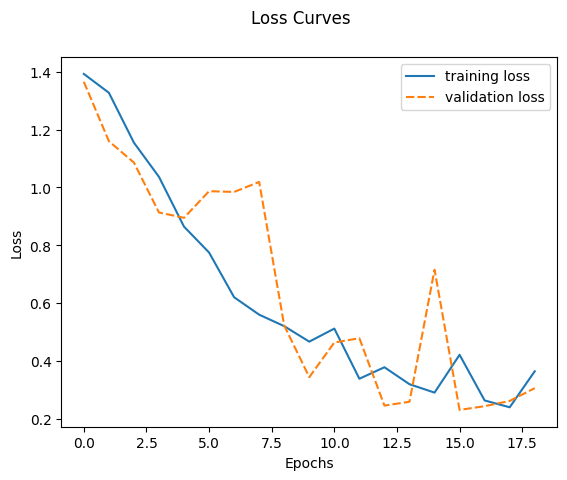

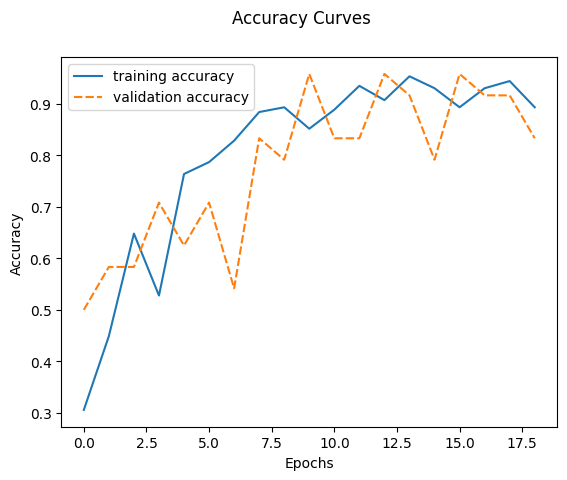

2/2 [==============================] - 0s 108ms/step


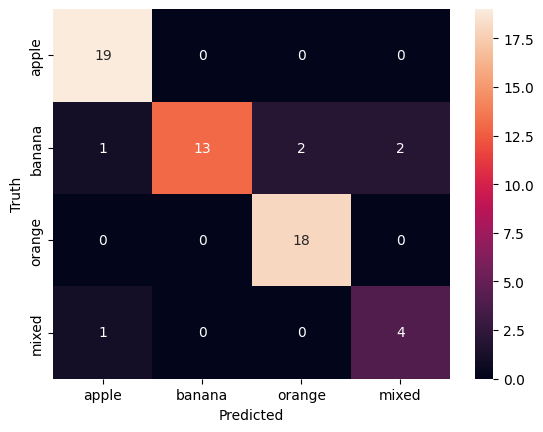

In [10]:
reset_instance_variables(reset_variables_dict)

## No edited variables

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 3. Increase Training Image Count Manually

Epoch 1/64
36/36 [==============================] - 11s 289ms/step - loss: 1.3871 - accuracy: 0.2667 - val_loss: 1.3775 - val_accuracy: 0.3250
Epoch 2/64
36/36 [==============================] - 11s 293ms/step - loss: 1.3031 - accuracy: 0.3889 - val_loss: 1.2282 - val_accuracy: 0.5250
Epoch 3/64
36/36 [==============================] - 10s 282ms/step - loss: 1.1075 - accuracy: 0.5417 - val_loss: 1.1391 - val_accuracy: 0.5500
Epoch 4/64
36/36 [==============================] - 10s 281ms/step - loss: 1.0065 - accuracy: 0.6278 - val_loss: 0.9809 - val_accuracy: 0.8000
Epoch 5/64
36/36 [==============================] - 10s 286ms/step - loss: 0.7848 - accuracy: 0.7222 - val_loss: 0.8213 - val_accuracy: 0.6750
Epoch 6/64
36/36 [==============================] - 10s 285ms/step - loss: 0.6162 - accuracy: 0.7889 - val_loss: 0.4835 - val_accuracy: 0.8500
Epoch 7/64
36/36 [==============================] - 10s 283ms/step - loss: 0.5322 - accuracy: 0.8139 - val_loss: 0.5778 - val_accuracy: 0.7000

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 109ms/step - loss: 0.3948 - accuracy: 0.9167
(23, 2)
    training loss  validation loss
18       0.259208         0.500049
19       0.236049         0.217257
20       0.221472         0.328084
21       0.286463         0.238912
22       0.217288         0.184323
(23, 2)
    training accuracy  validation accuracy
18           0.913889                0.875
19           0.905556                0.950
20           0.908333                0.900
21           0.886111                0.950
22           0.919444                0.950


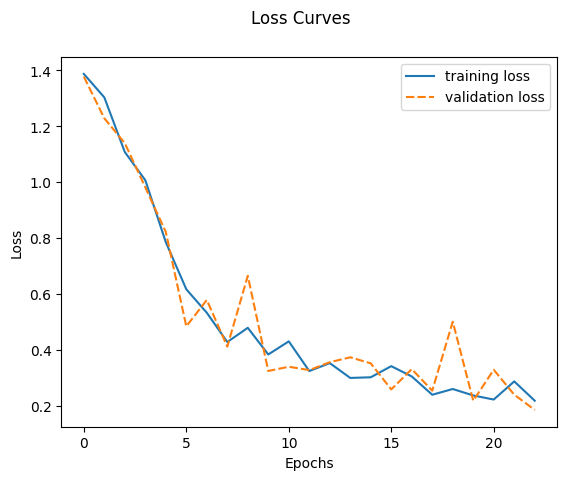

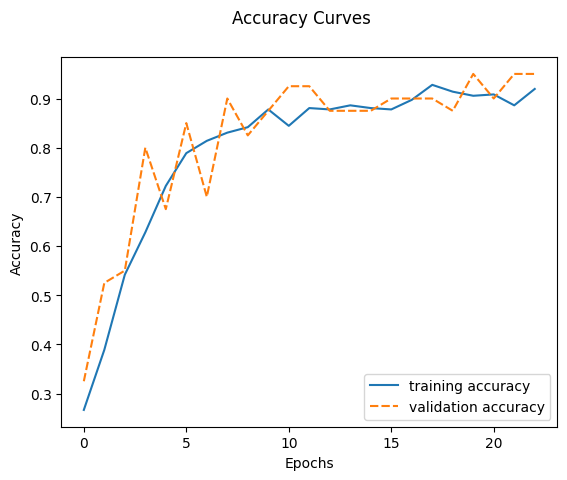

2/2 [==============================] - 0s 109ms/step


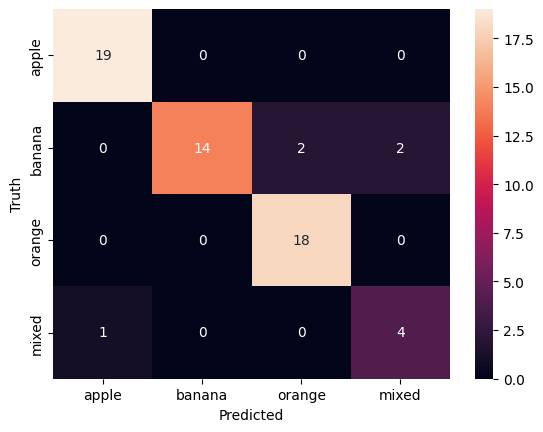

In [11]:
reset_instance_variables(reset_variables_dict)

var_data = '03EXPANDED' 

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 4. Maintain Aspect Ratio

Epoch 1/64
36/36 [==============================] - 11s 288ms/step - loss: 1.3912 - accuracy: 0.2056 - val_loss: 1.3847 - val_accuracy: 0.2250
Epoch 2/64
36/36 [==============================] - 10s 287ms/step - loss: 1.3064 - accuracy: 0.4278 - val_loss: 1.3899 - val_accuracy: 0.4750
Epoch 3/64
36/36 [==============================] - 10s 288ms/step - loss: 1.1281 - accuracy: 0.5028 - val_loss: 1.2890 - val_accuracy: 0.6000
Epoch 4/64
36/36 [==============================] - 10s 283ms/step - loss: 1.0507 - accuracy: 0.5750 - val_loss: 1.3098 - val_accuracy: 0.6500
Epoch 5/64
36/36 [==============================] - 10s 278ms/step - loss: 0.9487 - accuracy: 0.6500 - val_loss: 1.1844 - val_accuracy: 0.6500
Epoch 6/64
36/36 [==============================] - 10s 279ms/step - loss: 0.8546 - accuracy: 0.6778 - val_loss: 0.9778 - val_accuracy: 0.7250
Epoch 7/64
36/36 [==============================] - 10s 282ms/step - loss: 0.6881 - accuracy: 0.7389 - val_loss: 0.9278 - val_accuracy: 0.7500

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 107ms/step - loss: 0.2690 - accuracy: 0.9167
(25, 2)
    training loss  validation loss
20       0.386664         0.386963
21       0.410236         0.348486
22       0.274023         0.285093
23       0.246175         0.245848
24       0.303198         0.294132
(25, 2)
    training accuracy  validation accuracy
20           0.880556                0.850
21           0.869444                0.900
22           0.916667                0.900
23           0.922222                0.925
24           0.911111                0.925


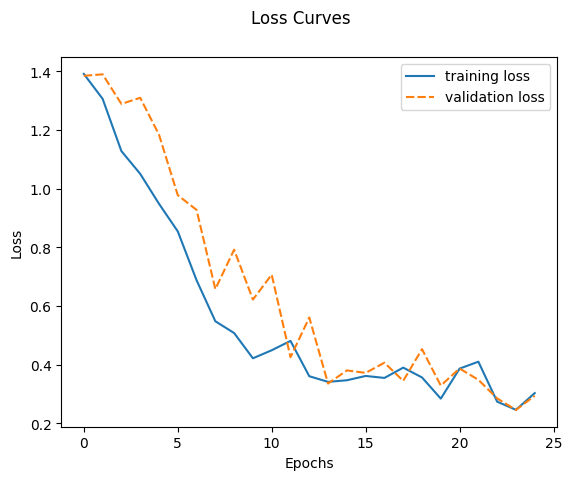

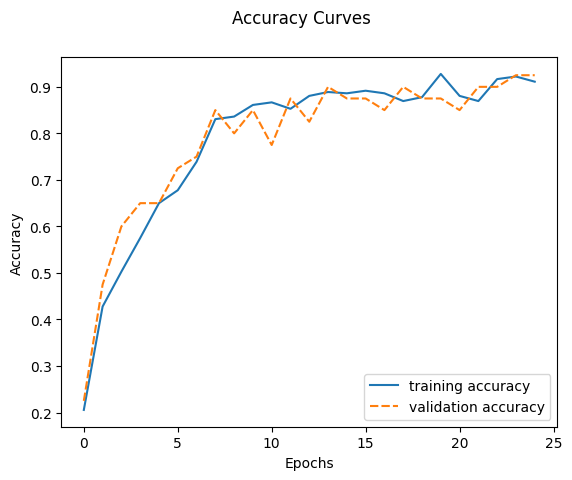

2/2 [==============================] - 0s 101ms/step


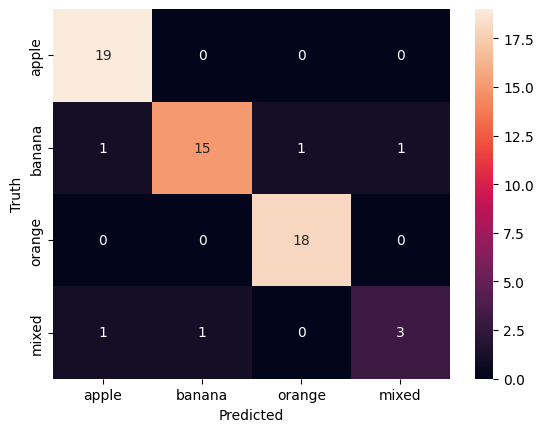

In [12]:
reset_instance_variables(reset_variables_dict)

retain_aspect_ratio = True 
var_data = '03EXPANDED' 

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 5. Image Size Rescaling

Epoch 1/64
22/22 [==============================] - 2s 65ms/step - loss: 1.4002 - accuracy: 0.2454 - val_loss: 1.3809 - val_accuracy: 0.2917
Epoch 2/64
22/22 [==============================] - 1s 60ms/step - loss: 1.3764 - accuracy: 0.2639 - val_loss: 1.3366 - val_accuracy: 0.2917
Epoch 3/64
22/22 [==============================] - 1s 60ms/step - loss: 1.1997 - accuracy: 0.5509 - val_loss: 0.9421 - val_accuracy: 0.6667
Epoch 4/64
22/22 [==============================] - 1s 60ms/step - loss: 0.9993 - accuracy: 0.6528 - val_loss: 0.8231 - val_accuracy: 0.5833
Epoch 5/64
22/22 [==============================] - 1s 60ms/step - loss: 0.8353 - accuracy: 0.7222 - val_loss: 0.6958 - val_accuracy: 0.7917
Epoch 6/64
22/22 [==============================] - 1s 60ms/step - loss: 0.8002 - accuracy: 0.7407 - val_loss: 0.6311 - val_accuracy: 0.7917
Epoch 7/64
22/22 [==============================] - 1s 60ms/step - loss: 0.7090 - accuracy: 0.7778 - val_loss: 1.0936 - val_accuracy: 0.5417
Epoch 8/64
22

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 25ms/step - loss: 0.7071 - accuracy: 0.8833
(37, 2)
    training loss  validation loss
32       0.096011         0.245843
33       0.108488         0.724813
34       0.134912         0.488036
35       0.248501         0.301486
36       0.095971         0.217802
(37, 2)
    training accuracy  validation accuracy
32           0.962963             0.916667
33           0.967593             0.916667
34           0.976852             0.916667
35           0.930556             0.875000
36           0.981481             0.916667


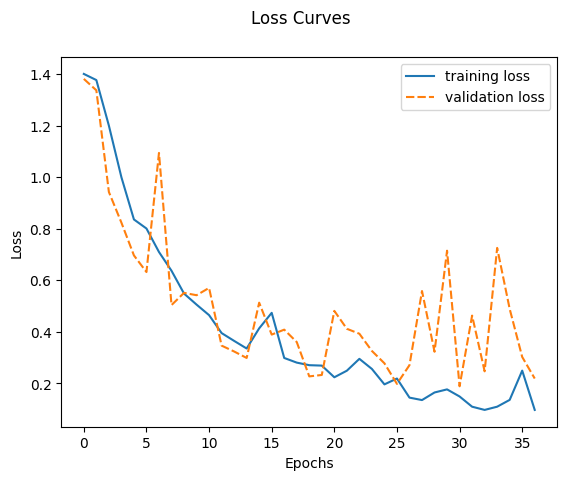

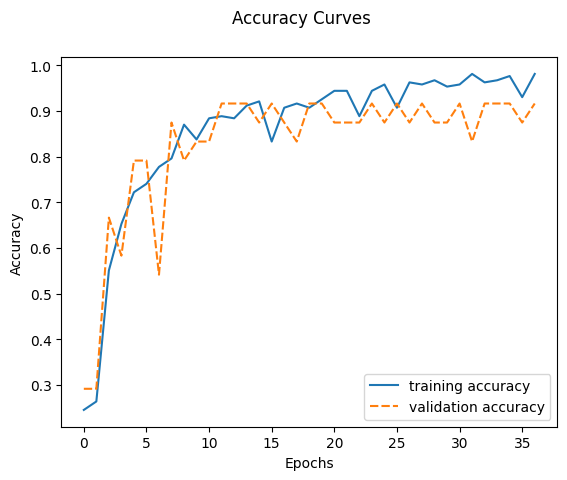

2/2 [==============================] - 0s 23ms/step


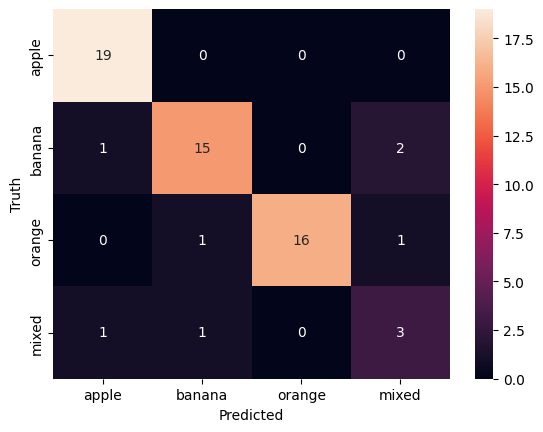

In [13]:
reset_instance_variables(reset_variables_dict)

img_size = 98

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 6. Data Preprocessing: Edge Mapping and Channels

Epoch 1/64
22/22 [==============================] - 7s 276ms/step - loss: 1.3904 - accuracy: 0.3009 - val_loss: 1.3824 - val_accuracy: 0.2917
Epoch 2/64
22/22 [==============================] - 6s 271ms/step - loss: 1.3877 - accuracy: 0.2917 - val_loss: 1.3540 - val_accuracy: 0.3750
Epoch 3/64
22/22 [==============================] - 6s 270ms/step - loss: 1.3854 - accuracy: 0.2407 - val_loss: 1.3771 - val_accuracy: 0.4583
Epoch 4/64
22/22 [==============================] - 6s 270ms/step - loss: 1.3811 - accuracy: 0.3102 - val_loss: 1.3492 - val_accuracy: 0.3333
Epoch 5/64
22/22 [==============================] - 6s 283ms/step - loss: 1.3807 - accuracy: 0.3796 - val_loss: 1.3648 - val_accuracy: 0.4167
Epoch 6/64
22/22 [==============================] - 6s 276ms/step - loss: 1.3780 - accuracy: 0.3148 - val_loss: 1.3337 - val_accuracy: 0.3750
Epoch 7/64
22/22 [==============================] - 6s 277ms/step - loss: 1.3799 - accuracy: 0.3796 - val_loss: 1.3517 - val_accuracy: 0.5000
Epoch 

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[Canny]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[Canny]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 107ms/step - loss: 1.3644 - accuracy: 0.4000
(17, 2)
    training loss  validation loss
12       1.361149         1.342178
13       1.357513         1.310167
14       1.348161         1.287916
15       1.371577         1.292426
16       1.345518         1.283035
(17, 2)
    training accuracy  validation accuracy
12           0.356481             0.416667
13           0.365741             0.458333
14           0.375000             0.375000
15           0.347222             0.375000
16           0.361111             0.583333


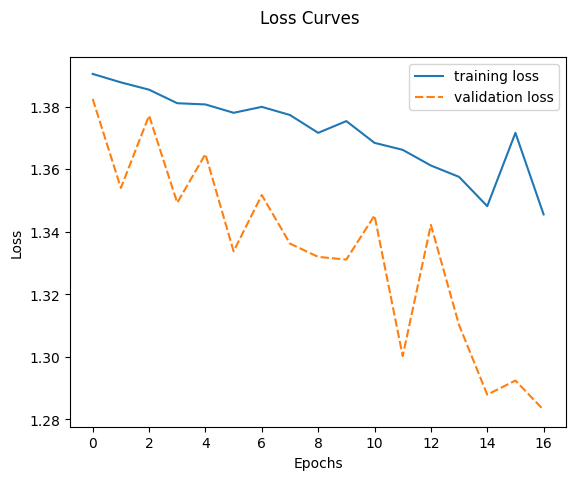

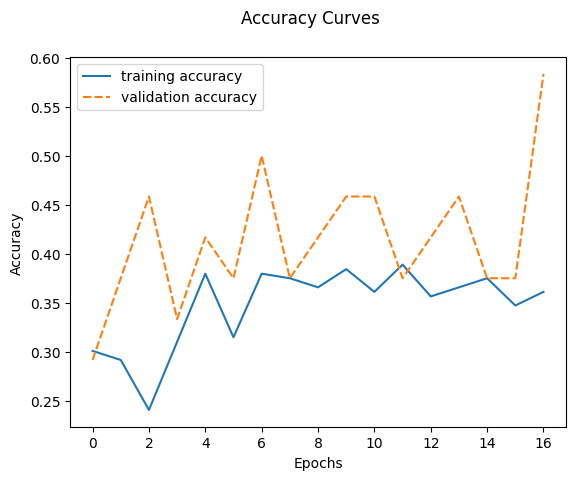

2/2 [==============================] - 0s 108ms/step


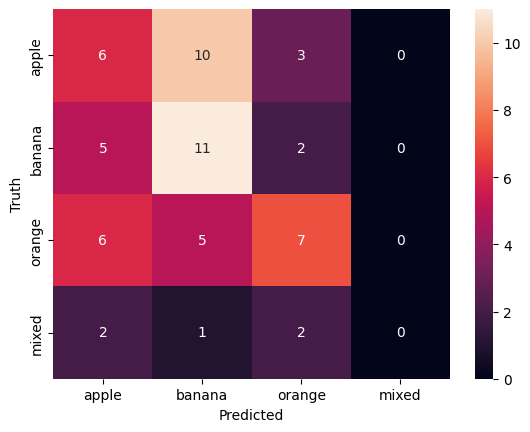

In [14]:
reset_instance_variables(reset_variables_dict)

var_aug= ['Canny', None]
    # OPTIONS: 
    # # First Aug
        #'RGB' # 'RGBcanny' # 'Grayscale' # 'Canny' 

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 7. Image Augmentation: Image Flipping

Epoch 1/64
22/22 [==============================] - 7s 287ms/step - loss: 1.3956 - accuracy: 0.2361 - val_loss: 1.3869 - val_accuracy: 0.1667
Epoch 2/64
22/22 [==============================] - 6s 279ms/step - loss: 1.3885 - accuracy: 0.2269 - val_loss: 1.3348 - val_accuracy: 0.5417
Epoch 3/64
22/22 [==============================] - 6s 276ms/step - loss: 1.3346 - accuracy: 0.5463 - val_loss: 1.1291 - val_accuracy: 0.6250
Epoch 4/64
22/22 [==============================] - 6s 278ms/step - loss: 1.1420 - accuracy: 0.5741 - val_loss: 0.9528 - val_accuracy: 0.5833
Epoch 5/64
22/22 [==============================] - 6s 275ms/step - loss: 1.0335 - accuracy: 0.6435 - val_loss: 0.8163 - val_accuracy: 0.6250
Epoch 6/64
22/22 [==============================] - 6s 275ms/step - loss: 0.9293 - accuracy: 0.6250 - val_loss: 0.7579 - val_accuracy: 0.6250
Epoch 7/64
22/22 [==============================] - 6s 276ms/step - loss: 0.9107 - accuracy: 0.6574 - val_loss: 0.7597 - val_accuracy: 0.6667
Epoch 

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[flip_horizontal]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[flip_horizontal]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 116ms/step - loss: 0.4955 - accuracy: 0.8500
(29, 2)
    training loss  validation loss
24       0.304096         0.185681
25       0.281305         0.122940
26       0.244176         0.097562
27       0.326880         0.151172
28       0.301968         0.405958
(29, 2)
    training accuracy  validation accuracy
24           0.930556             0.916667
25           0.912037             1.000000
26           0.930556             1.000000
27           0.935185             0.958333
28           0.925926             0.875000


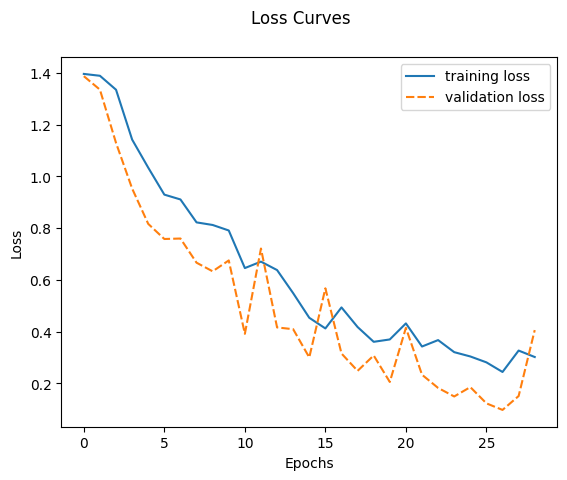

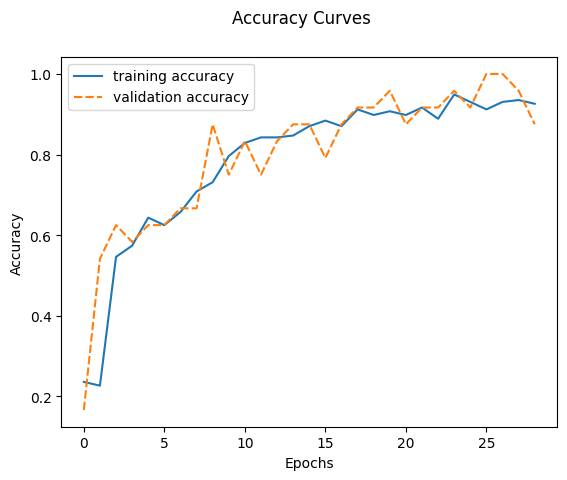

2/2 [==============================] - 0s 109ms/step


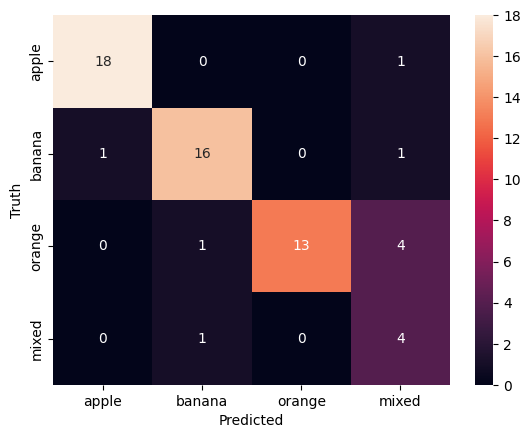

In [15]:
reset_instance_variables(reset_variables_dict)

var_aug= ['RGB', "flip_horizontal"]

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 8. Image Augmentation: Image Translation

Epoch 1/64
22/22 [==============================] - 7s 283ms/step - loss: 1.3923 - accuracy: 0.1944 - val_loss: 1.3805 - val_accuracy: 0.1667
Epoch 2/64
22/22 [==============================] - 6s 276ms/step - loss: 1.3354 - accuracy: 0.4398 - val_loss: 1.1808 - val_accuracy: 0.6250
Epoch 3/64
22/22 [==============================] - 6s 278ms/step - loss: 1.0763 - accuracy: 0.5926 - val_loss: 0.9486 - val_accuracy: 0.5000
Epoch 4/64
22/22 [==============================] - 6s 278ms/step - loss: 0.9654 - accuracy: 0.6296 - val_loss: 0.9450 - val_accuracy: 0.6667
Epoch 5/64
22/22 [==============================] - 6s 276ms/step - loss: 0.8363 - accuracy: 0.7269 - val_loss: 1.0809 - val_accuracy: 0.7083
Epoch 6/64
22/22 [==============================] - 6s 276ms/step - loss: 0.6781 - accuracy: 0.8056 - val_loss: 1.0349 - val_accuracy: 0.7083
Epoch 7/64
22/22 [==============================] - 6s 276ms/step - loss: 0.6673 - accuracy: 0.7778 - val_loss: 0.6709 - val_accuracy: 0.8333
Epoch 

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[translation]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[01RELABELLED]-[RGB]-[translation]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 114ms/step - loss: 0.8076 - accuracy: 0.8667
(16, 2)
    training loss  validation loss
11       0.399121         0.421926
12       0.366236         0.331420
13       0.397281         0.414310
14       0.468372         0.319984
15       0.388897         0.369283
(16, 2)
    training accuracy  validation accuracy
11           0.884259             0.833333
12           0.912037             0.833333
13           0.902778             0.791667
14           0.865741             0.875000
15           0.912037             0.833333


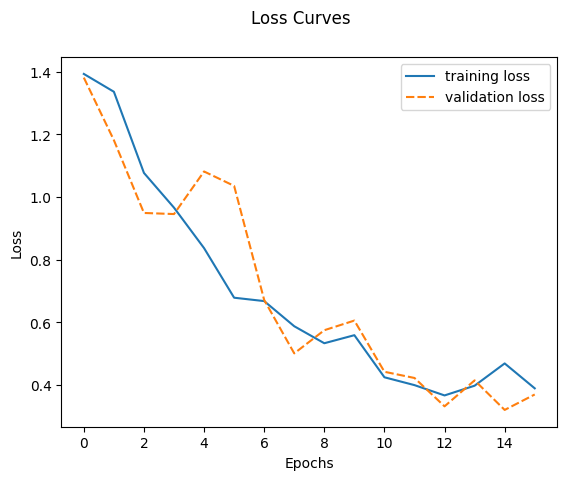

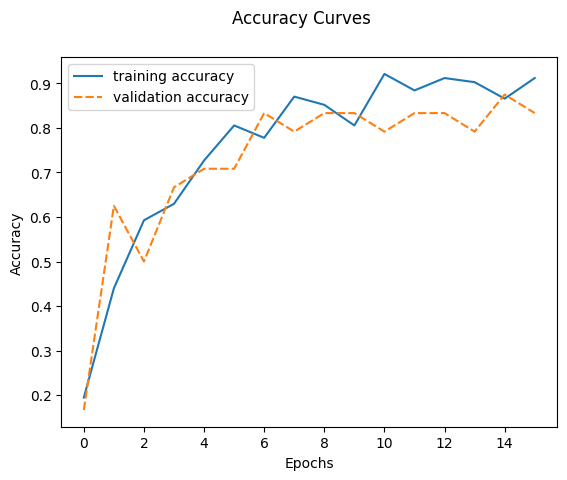

2/2 [==============================] - 0s 117ms/step


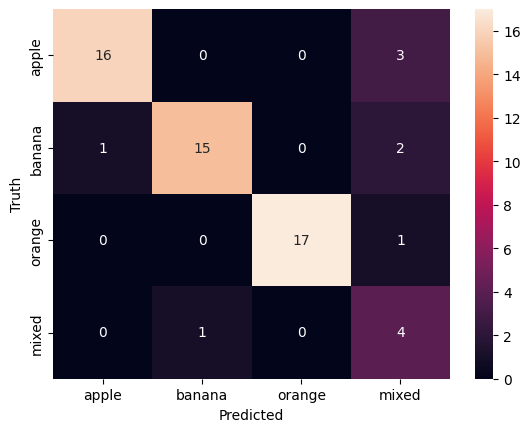

In [16]:
reset_instance_variables(reset_variables_dict)

var_aug= ['RGB', "translation"]

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 9. Model Augmentation: Adjusting Layers

Epoch 1/64
22/22 [==============================] - 19s 802ms/step - loss: 1.4163 - accuracy: 0.2870 - val_loss: 1.3789 - val_accuracy: 0.2917
Epoch 2/64
22/22 [==============================] - 17s 779ms/step - loss: 1.3895 - accuracy: 0.1991 - val_loss: 1.3873 - val_accuracy: 0.1250
Epoch 3/64
22/22 [==============================] - 18s 815ms/step - loss: 1.3831 - accuracy: 0.3009 - val_loss: 1.2900 - val_accuracy: 0.3750
Epoch 4/64
22/22 [==============================] - 18s 797ms/step - loss: 1.2540 - accuracy: 0.4444 - val_loss: 0.8843 - val_accuracy: 0.6667
Epoch 5/64
22/22 [==============================] - 17s 793ms/step - loss: 1.1319 - accuracy: 0.6111 - val_loss: 0.8315 - val_accuracy: 0.6250
Epoch 6/64
22/22 [==============================] - 18s 819ms/step - loss: 1.0577 - accuracy: 0.6296 - val_loss: 0.9056 - val_accuracy: 0.5833
Epoch 7/64
22/22 [==============================] - 17s 780ms/step - loss: 1.0277 - accuracy: 0.5370 - val_loss: 0.7618 - val_accuracy: 0.5833

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Overtuned]-[01RELABELLED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Overtuned]-[01RELABELLED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 1s 454ms/step - loss: 1.4002 - accuracy: 0.5333
(15, 2)
    training loss  validation loss
10       1.122865         0.843791
11       0.999107         0.737636
12       0.838480         0.665798
13       0.846936         0.713248
14       0.819337         0.702083
(15, 2)
    training accuracy  validation accuracy
10           0.393519             0.500000
11           0.620370             0.583333
12           0.629630             0.625000
13           0.601852             0.583333
14           0.606481             0.625000


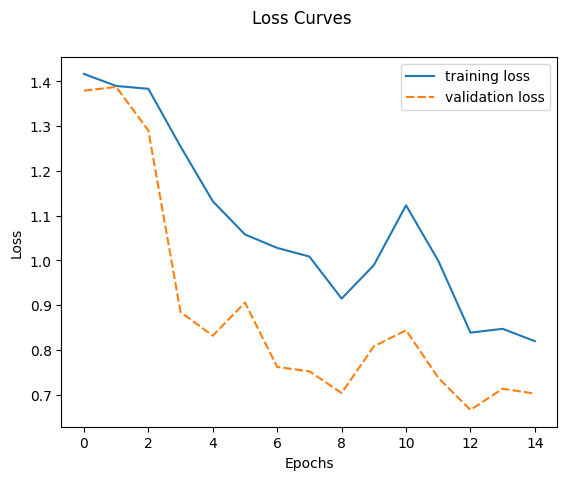

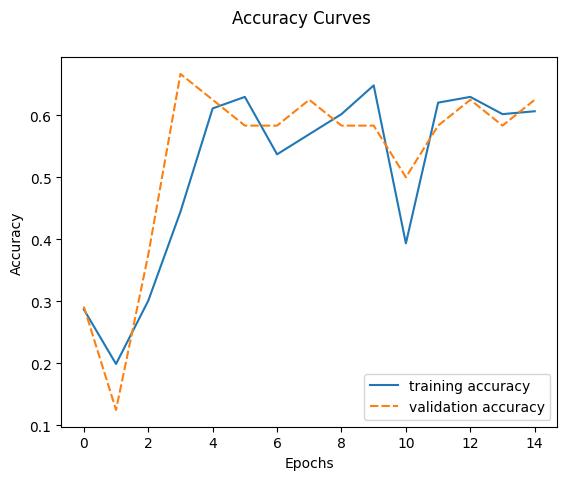

2/2 [==============================] - 1s 453ms/step


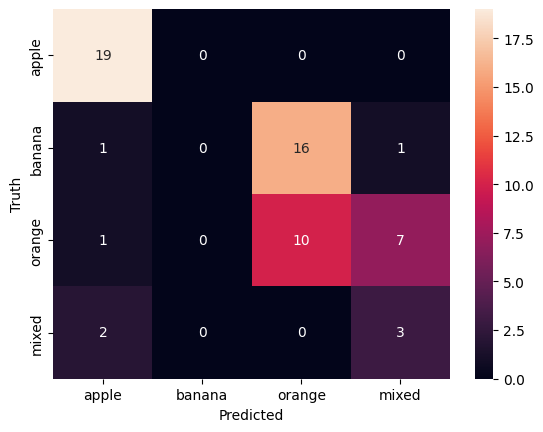

In [17]:
reset_instance_variables(reset_variables_dict)

var_model = 'Overtuned'

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 10. Model Augmentation: Adjust Kernel Size

Epoch 1/64
22/22 [==============================] - 87s 4s/step - loss: 1.4268 - accuracy: 0.2454 - val_loss: 1.3470 - val_accuracy: 0.2500
Epoch 2/64
22/22 [==============================] - 86s 4s/step - loss: 1.3856 - accuracy: 0.2176 - val_loss: 1.3831 - val_accuracy: 0.2917
Epoch 3/64
22/22 [==============================] - 84s 4s/step - loss: 1.3761 - accuracy: 0.3009 - val_loss: 1.3754 - val_accuracy: 0.4583
Epoch 4/64
22/22 [==============================] - 82s 4s/step - loss: 1.3749 - accuracy: 0.3843 - val_loss: 1.3625 - val_accuracy: 0.4583
Epoch 5/64
22/22 [==============================] - 85s 4s/step - loss: 1.3875 - accuracy: 0.3194 - val_loss: 1.3772 - val_accuracy: 0.3750
Epoch 6/64
22/22 [==============================] - 84s 4s/step - loss: 1.3718 - accuracy: 0.4213 - val_loss: 1.3141 - val_accuracy: 0.5000
Epoch 7/64
22/22 [==============================] - 91s 4s/step - loss: 1.3147 - accuracy: 0.4028 - val_loss: 1.2621 - val_accuracy: 0.4167
Epoch 8/64
22/22 [==

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[9x9]-[01RELABELLED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[9x9]-[01RELABELLED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 8s 4s/step - loss: 0.9018 - accuracy: 0.5833
(18, 2)
    training loss  validation loss
13       0.999756         0.724879
14       2.752761         1.560303
15       1.310688         1.196483
16       1.188433         0.903227
17       1.123519         0.685170
(18, 2)
    training accuracy  validation accuracy
13           0.532407             0.750000
14           0.388889             0.083333
15           0.333333             0.500000
16           0.587963             0.708333
17           0.537037             0.791667


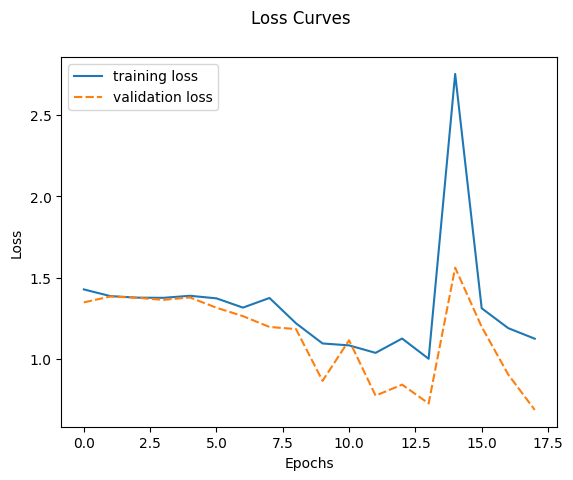

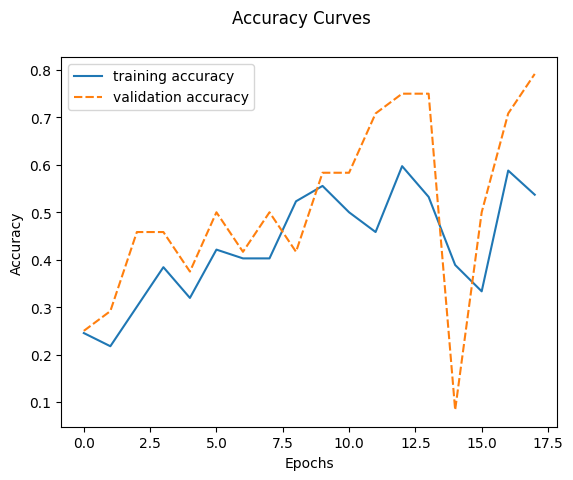

2/2 [==============================] - 8s 3s/step


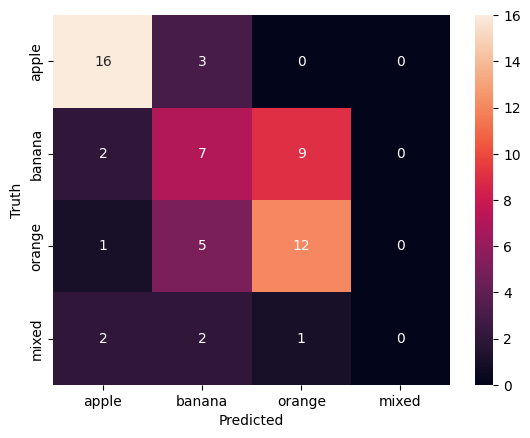

In [18]:
reset_instance_variables(reset_variables_dict)

var_model = '9x9' 

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## 11. Model Augmentation: Random oversampling

Epoch 1/64
46/46 [==============================] - 6s 119ms/step - loss: 1.3334 - accuracy: 0.3326 - val_loss: 1.3009 - val_accuracy: 0.2549
Epoch 2/64
46/46 [==============================] - 4s 96ms/step - loss: 1.0564 - accuracy: 0.5514 - val_loss: 0.8980 - val_accuracy: 0.6275
Epoch 3/64
46/46 [==============================] - 4s 96ms/step - loss: 0.7922 - accuracy: 0.7155 - val_loss: 0.6230 - val_accuracy: 0.7255
Epoch 4/64
46/46 [==============================] - 4s 96ms/step - loss: 0.7005 - accuracy: 0.7571 - val_loss: 0.6181 - val_accuracy: 0.7255
Epoch 5/64
46/46 [==============================] - 4s 96ms/step - loss: 0.5496 - accuracy: 0.7943 - val_loss: 0.5029 - val_accuracy: 0.8039
Epoch 6/64
46/46 [==============================] - 4s 97ms/step - loss: 0.5194 - accuracy: 0.7987 - val_loss: 0.4529 - val_accuracy: 0.8431
Epoch 7/64
46/46 [==============================] - 4s 96ms/step - loss: 0.4588 - accuracy: 0.8162 - val_loss: 0.4956 - val_accuracy: 0.7843
Epoch 8/64
4

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[02INCREASED]-[RGB]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[02INCREASED]-[RGB]-[None]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 37ms/step - loss: 0.4598 - accuracy: 0.8667
(27, 2)
    training loss  validation loss
22       0.224247         0.407640
23       0.279717         0.173766
24       0.180259         0.199290
25       0.164390         0.277872
26       0.203421         0.512202
(27, 2)
    training accuracy  validation accuracy
22           0.916849             0.843137
23           0.892779             0.960784
24           0.932166             0.901961
25           0.934354             0.921569
26           0.929978             0.862745


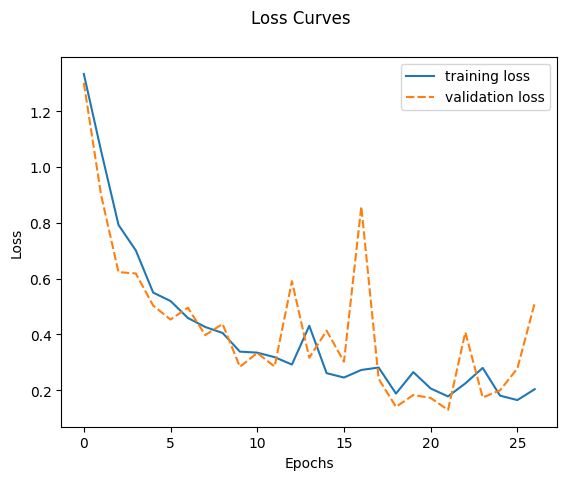

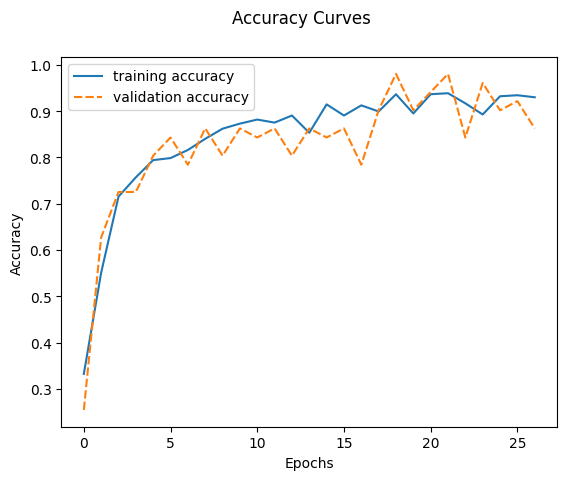

2/2 [==============================] - 0s 37ms/step


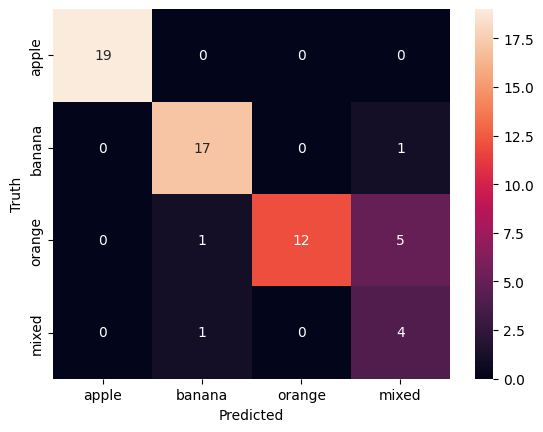

In [19]:
reset_instance_variables(reset_variables_dict)

var_data = '02INCREASED'
img_size = 124
use_random_oversampling = True

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

# Recommended Models

<b>RATIONALE:</b>

Despite not having the highest accuracy, we chose a combination of settings based on our group's findings that produced a consistently high accuracy value, low loss value and well-fitted graph. 

## High Accuracy v1

Epoch 1/64
32/32 [==============================] - 7s 26ms/step - loss: 1.3899 - accuracy: 0.2500 - val_loss: 1.3750 - val_accuracy: 0.4125
Epoch 2/64
32/32 [==============================] - 1s 20ms/step - loss: 1.3241 - accuracy: 0.4250 - val_loss: 1.0911 - val_accuracy: 0.4750
Epoch 3/64
32/32 [==============================] - 1s 20ms/step - loss: 1.1833 - accuracy: 0.4844 - val_loss: 1.0724 - val_accuracy: 0.4750
Epoch 4/64
32/32 [==============================] - 1s 20ms/step - loss: 1.2050 - accuracy: 0.5094 - val_loss: 1.1030 - val_accuracy: 0.5500
Epoch 5/64
32/32 [==============================] - 1s 20ms/step - loss: 1.1243 - accuracy: 0.5188 - val_loss: 0.9810 - val_accuracy: 0.5250
Epoch 6/64
32/32 [==============================] - 1s 20ms/step - loss: 1.0216 - accuracy: 0.5906 - val_loss: 0.9546 - val_accuracy: 0.6000
Epoch 7/64
32/32 [==============================] - 1s 20ms/step - loss: 0.9042 - accuracy: 0.6687 - val_loss: 0.6811 - val_accuracy: 0.7625
Epoch 8/64
32

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_horizontal]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_horizontal]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 1s 339ms/step - loss: 0.2919 - accuracy: 0.9167
(18, 2)
    training loss  validation loss
13       0.280521         0.527054
14       0.557241         0.261083
15       0.340459         0.283560
16       0.297640         0.266846
17       0.244804         0.230371
(18, 2)
    training accuracy  validation accuracy
13           0.909375               0.8375
14           0.862500               0.9125
15           0.890625               0.9250
16           0.918750               0.8500
17           0.918750               0.9000


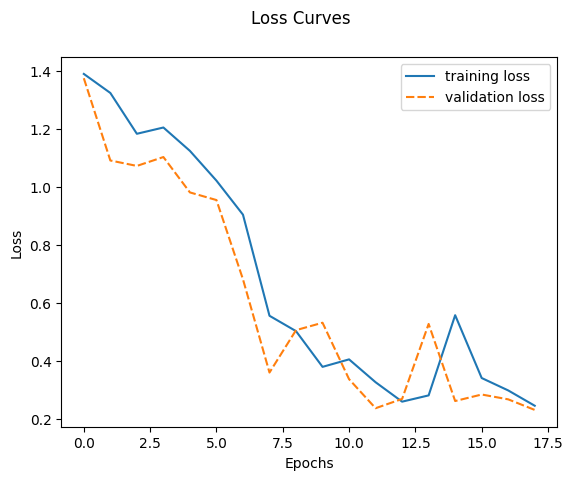

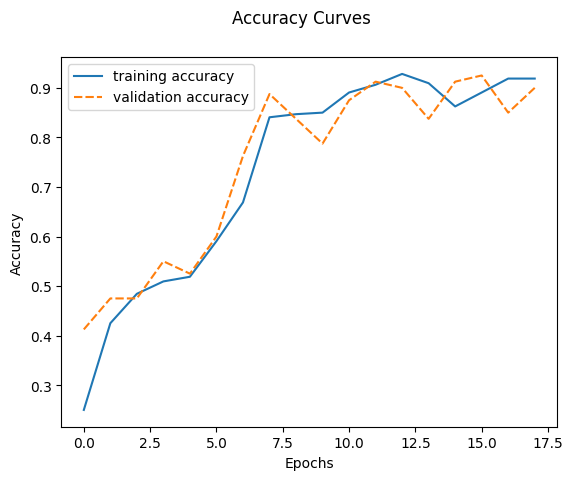

2/2 [==============================] - 0s 15ms/step


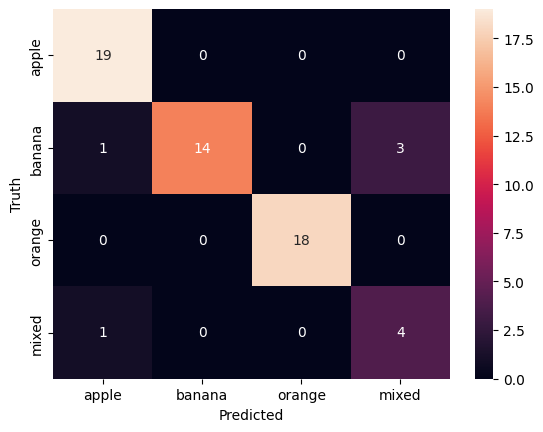

In [12]:
HAOG_variables_dict = {
    # (12x-Apples-Dataset)
    'img_size' : 224,
    'epochs' : 64,
    'batchsize' : 10, 
    'validation_split' :0.2,
    'patience_value' : 5 ,
    'retain_aspect_ratio' : True,
    'use_classweights' : True,
    'use_random_oversampling' : True,
    'var_model' : 'Optimal',
    'var_data' : '03EXPANDED',
    'var_aug' : ['RGBcanny', "flip_horizontal"],
}

reset_instance_variables(HAOG_variables_dict)

# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')

## High Accuracy v2

Epoch 1/64
32/32 [==============================] - 2s 36ms/step - loss: 1.3885 - accuracy: 0.2406 - val_loss: 1.3815 - val_accuracy: 0.2375
Epoch 2/64
32/32 [==============================] - 1s 21ms/step - loss: 1.3640 - accuracy: 0.2937 - val_loss: 1.3409 - val_accuracy: 0.3375
Epoch 3/64
32/32 [==============================] - 1s 21ms/step - loss: 1.2471 - accuracy: 0.4313 - val_loss: 1.1503 - val_accuracy: 0.6250
Epoch 4/64
32/32 [==============================] - 1s 21ms/step - loss: 1.0004 - accuracy: 0.5938 - val_loss: 1.0288 - val_accuracy: 0.5500
Epoch 5/64
32/32 [==============================] - 1s 20ms/step - loss: 0.8824 - accuracy: 0.6781 - val_loss: 0.9300 - val_accuracy: 0.6125
Epoch 6/64
32/32 [==============================] - 1s 21ms/step - loss: 0.8354 - accuracy: 0.6750 - val_loss: 1.0616 - val_accuracy: 0.5000
Epoch 7/64
32/32 [==============================] - 1s 21ms/step - loss: 0.8343 - accuracy: 0.6469 - val_loss: 0.8365 - val_accuracy: 0.6875
Epoch 8/64
32

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_vertical_horizontal]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_vertical_horizontal]\assets


    [==============================]=============EVALUATE AGAINST TEST DATA=============
2/2 [==============================] - 0s 16ms/step - loss: 0.2033 - accuracy: 0.9333
(29, 2)
    training loss  validation loss
24       0.357898         0.397290
25       0.258240         0.279783
26       0.179744         0.252320
27       0.185594         0.235189
28       0.253635         0.288616
(29, 2)
    training accuracy  validation accuracy
24           0.881250               0.8625
25           0.893750               0.9125
26           0.934375               0.9000
27           0.943750               0.9375
28           0.925000               0.9125


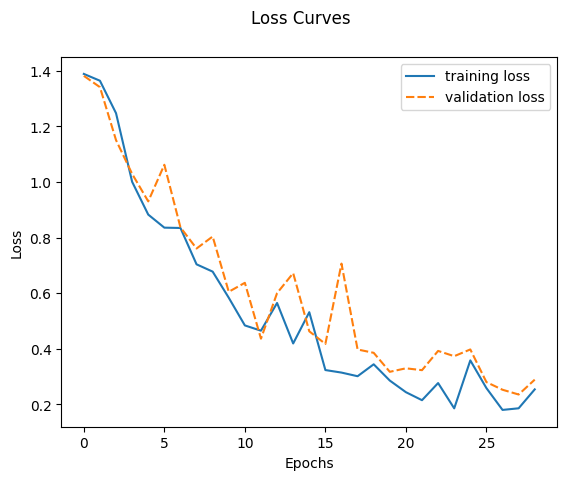

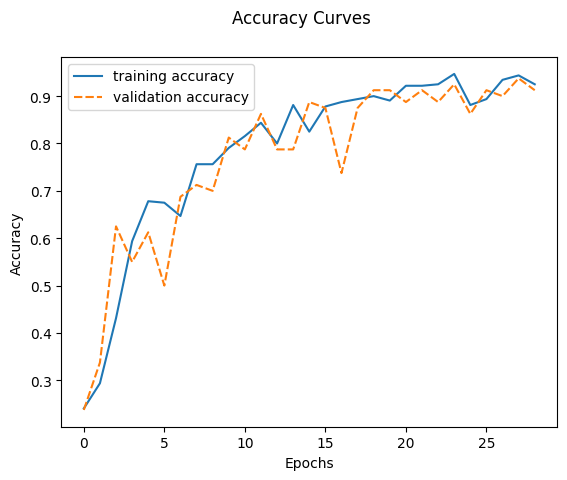

2/2 [==============================] - 0s 15ms/step


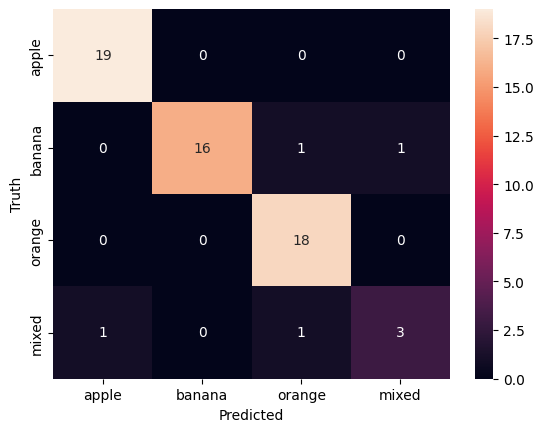

In [13]:
HAFG_variables_dict = {
    # 230527 0942AM model (100-Balanced-Dataset)
    'img_size' : 224,
    'epochs' : 64,
    'batchsize' : 10, 
    'validation_split' :0.2,
    'patience_value' : 5 ,
    'retain_aspect_ratio' : True,
    'use_classweights' : True,
    'use_random_oversampling' : False,
    'var_model' : 'Optimal',
    'var_data' : '03EXPANDED',
    'var_aug' : ['RGBcanny', "flip_vertical_horizontal"],
}


reset_instance_variables(HAFG_variables_dict)


# -------------------DATA PREP--------------
X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

set_automatic_variables()

# -------------------CLASS WEIGHTS--------------
class_weights = assign_class_weights(use_classweights, y_data)

# -------------------CREATE MODEL---------------
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# -------------------TRAIN + SAVE MODEL---------------

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

# -------------------EVALUATE AGAINST \TEST\ DATA------------
model = load_model(model_data_id)
print("    [==============================]=============EVALUATE AGAINST TEST DATA=============")
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)

# -------------------SET + SHOW GRAPHING DATA----------------
df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())
# ------------------PLOT LOSS+ACCURACY GRAPHS--------------
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()

# ------------------PLOT HEAT MAP--------------
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')